# Import

In [2]:
import pandas as pd
from scipy.stats import skew
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition, cluster, metrics
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import folium

On importe les différentes librairies nécessaires.

# Création du jeu de données

## Lecture des fichiers .csv

In [3]:
dispo_alim = pd.read_csv("./data/DAN-P9-data/DisponibiliteAlimentaire_2017.csv")
pop = pd.read_csv("./data/DAN-P9-data/Population_2000_2018.csv")
pib = pd.read_csv("./data/pib.csv")
distance = pd.read_csv("./data/distance.csv", delimiter=';')
stabilité = pd.read_csv("./data/PoliticalStability.csv", delimiter=';')

fr = pd.read_csv("./data/fr.csv")
en = pd.read_csv("./data/en.csv")

## Création du dataset

Dans ce projet il est demandé de réaliser une analyse pour une entreprise qui vend du poulet et qui souhaite s'exporter à l'international. Pour cela nous allons analyser la consomation et l'importation des différents pays en poulet pour savoir lesquels pourraient représenter des nouveaux marchés intéressant pour l'entreprise.

Nous ne pourrons pas avoir des données pour chaques critères mais nous en utiliserons un maximum.

Il est mentionné dans le sujet de prendre en compte les critères donnés par la méthode PESTEL :
  - Pour ce qui est de la composante politique nous allons utiliser un indicateur de stabilité politique que nous avons déjà utilisé dans un précedant projet.
  - Pour le critère économique nous utiliserons le PIB par habitant.
  - Pour la partie socioculturel nous utliserons la quantité de population.
  - Enfin pour ce qui est du volet écologique de l'analyse nous utliserons la distance des pays par rapport à la France, pays d'origine de l'entreprise.

### Traduction

In [4]:
trad = pd.merge(fr[['Code zone', 'Zone']], en[['Area Code', 'Area']], left_on='Code zone', right_on='Area Code', how='inner')
trad = trad.drop_duplicates()
trad.rename(columns = {'Zone':'fr', 'Area':'en'}, inplace = True)
trad = trad[['fr','en']]

On crée une table avec en colonne les noms des pays en français d'un coté et en anglais de l'autre. On s'en servira plus tard pour traduire les colonnes de pays en anglais.

### Distance

Après avoir fait des recherches sur internet et n'ayant pas trouvé de données rapidement exploitable avec mes connaissances actuelles j'ai décidé de créer un scrapper pour récupérer les données d'un site qui affiche les distances entre un pays choisit et tous les autres.

In [5]:
distance.head()

,Unnamed: 0,Zone,Distance
0,0,Afghanistan,5572
1,1,Afrique du Sud,8665
2,2,Albanie,1599
3,3,Algérie,1336
4,4,Allemagne,877


On regarde un extrait des données de la table pour voir si elles ont besoin d'être modifier et il semble que non.

In [6]:
distance = distance[['Zone', 'Distance']]

On vérifie que les données scrapper contient un maximum de pays correspondent aux pays de la table disponibilité alimentaire que nous utiliseront comme "base" pour notre jeu de données.

In [7]:
pays = distance['Zone'].unique()
sim = dispo_alim[~dispo_alim.Zone.isin(pays)]['Zone'].unique()
print('Nombre de valeur manquantes :', len(sim))
sim

Nombre de valeur manquantes : 3


array(['Chine - RAS de Macao', 'France', 'Sainte-Lucie'], dtype=object)

Il ressort que 3 pays ne correspondent pas, on peut conclure que les données scrapper sont utilisables. Nous les corrigerons par la suite.

### Stabilité politique

In [8]:
stabilité.head(20)

,Country,Year,Political_Stability,Granularity
0,Afghanistan,2000,-2.44,Total
1,Afghanistan,2002,-2.04,Total
2,Afghanistan,2003,-2.20,Total
3,Afghanistan,2004,-2.30,Total
4,Afghanistan,2005,-2.07,Total
5,Afghanistan,2006,-2.22,Total
6,Afghanistan,2007,-2.41,Total
7,Afghanistan,2008,-2.69,Total
8,Afghanistan,2009,-2.71,Total
9,Afghanistan,2010,-2.58,Total


On regarde un extrait des données de la table pour voir si elles ont besoin d'être modifier. On voit que plusieurs années apparaissent pour chaque pays et qu'une colonne granularité apparait mais ne nous interesse pas. Enfin lorsqu'on regarde un peu plus de données on voit que les noms des pays sont en anglais.

In [9]:
stabilité = stabilité.loc[stabilité['Year'] == 2017]
stabilité = pd.merge(stabilité, trad, left_on='Country', right_on='en')
stabilité = stabilité[['fr', 'Political_Stability']]
stabilité.rename(columns={'fr':'Zone', 'Political_Stability':'Stabilité'}, inplace = True)

Ici on ne filtre les pays sur l'année 2017 pour rester cohérent avec les données dont nous disposons déjà, ensuite on traduit les noms de pays et on ne garde que les colonne qui nous interessent.

In [10]:
pays = stabilité['Zone'].unique()
sim = dispo_alim[~dispo_alim.Zone.isin(pays)]['Zone'].unique()
print('Nombre de valeur manquantes :', len(sim))
sim

Nombre de valeur manquantes : 9


array(['Chine, continentale', 'Chine, Taiwan Province de', 'Cuba',
       'Nouvelle-Calédonie', 'Polynésie française',
       'République populaire démocratique de Corée', 'Turquie',
       'Venezuela (République bolivarienne du)', 'Yémen'], dtype=object)

Enfin on vérifie que tous les pays on bien été traduit, qu'ils correspondent avec la table de disponibilité alimentaire et que les données soient bien exploitable. On voit que 9 pays ne correspondent pas, ca reste peu donc les données sont bien exploitables.

### Disponibilité alimentaire

In [11]:
dispo_alim.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2511,Blé et produits,2017,2017,Milliers de tonnes,4281.0,S,Données standardisées
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,2302.0,S,Données standardisées
2,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2511,Blé et produits,2017,2017,Milliers de tonnes,-119.0,S,Données standardisées
3,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5911,Exportations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,0.0,S,Données standardisées
4,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5301,Disponibilité intérieure,2511,Blé et produits,2017,2017,Milliers de tonnes,6701.0,S,Données standardisées


On regarde un extrait des données et on voit qu'il faut trier les produits sur la viandes de volailles qui est le produit qui nous intéresse.

In [12]:
dispo_alim = dispo_alim[dispo_alim['Produit'] == 'Viande de Volailles']
dispo_alim = dispo_alim[['Zone', 'Élément', 'Valeur']]

On trie les produits sur la viande de volailles et on garde les colonnes qui nous intéresse.

In [13]:
dispo_alim = dispo_alim.pivot_table(values='Valeur', index='Zone', columns='Élément')

On pivote la table pour que la colonne éléments se séparent en différentes colonnes.

In [14]:
dispo_alim.head()

Élément,Alimentation pour touristes,Aliments pour animaux,Autres utilisations (non alimentaire),Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Pertes,Production,Résidus,Semences,Traitement,Variation de stock
Zone,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,5.0,1.53,0.33,0.54,57.0,NaN,29.0,55.0,2.0,28.0,0.0,NaN,NaN,0.0
Afrique du Sud,0.0,NaN,NaN,143.0,35.69,9.25,14.11,2118.0,63.0,514.0,2035.0,83.0,1667.0,0.0,NaN,NaN,0.0
Albanie,NaN,NaN,NaN,85.0,16.36,6.45,6.26,47.0,0.0,38.0,47.0,NaN,13.0,0.0,NaN,NaN,4.0
Algérie,0.0,NaN,NaN,22.0,6.38,1.50,1.97,277.0,0.0,2.0,264.0,13.0,275.0,0.0,NaN,NaN,0.0
Allemagne,NaN,NaN,NaN,71.0,19.47,4.16,7.96,1739.0,646.0,842.0,1609.0,NaN,1514.0,-38.0,NaN,167.0,-29.0


In [15]:
dispo_alim = dispo_alim[['Importations - Quantité', 'Nourriture', 'Production']]

Enfin on garde seulement les éléments qui nous interessent pour notre analyse.

### Population

In [16]:
temp = pop[pop['Année'].isin([2012, 2017])][['Zone', 'Valeur', 'Année']]
temp = temp.pivot_table(values='Valeur', index='Zone', columns='Année')
temp['Variation'] = (temp[2017] - temp[2012]) / temp[2017]
temp = temp.reset_index()

On crée une nouvelle variable variation qui contiendra la variation en population entre 2012 et 2017 pour avoir la dynamique démographique du pays.

In [17]:
pop = pop[pop['Année'] == 2017][['Zone', 'Valeur']]
pop['Population'] = pop['Valeur']*1000
pop = pop.drop(['Valeur'], axis=1)

Enfin on garde la quantité de population de l'année 2017 pour rester cohérent avec le reste des données.

In [18]:
pop = pd.merge(pop, temp[['Zone', 'Variation']], how='inner')

On merge la variation et la quantité de population.

### PIB

In [19]:
pib.head()

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,MK,Indicateurs macro,4,Afghanistan,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,520.616409,X,Ciffre de sources internationales,NaN
1,MK,Indicateurs macro,710,Afrique du Sud,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,6121.876572,X,Ciffre de sources internationales,NaN
2,MK,Indicateurs macro,8,Albanie,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,4514.204908,X,Ciffre de sources internationales,NaN
3,MK,Indicateurs macro,12,Algérie,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,4109.696001,X,Ciffre de sources internationales,NaN
4,MK,Indicateurs macro,276,Allemagne,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,44651.829102,X,Ciffre de sources internationales,NaN


On regarde un extrait des données.

In [20]:
pib = pib[['Zone', 'Valeur']]
pib.rename(columns = {'Valeur':'Pib'}, inplace = True)

On garde seulement les colonne Zone et Valeur qui sont celles qui nous interessent.

### Merge

In [21]:
df = pd.merge(dispo_alim, pop, on='Zone', how='left')
df = pd.merge(df, distance, on='Zone', how='left')
df = pd.merge(df, pib, on='Zone', how='left')
df = pd.merge(df, stabilité, on='Zone', how='left')
df

,Zone,Importations - Quantité,Nourriture,Production,Population,Variation,Distance,Pib,Stabilité
0,Afghanistan,29.0,55.0,28.0,36296113.0,0.141468,5572.0,520.616409,-2.80
1,Afrique du Sud,514.0,2035.0,1667.0,57009756.0,0.073270,8665.0,6121.876572,-0.28
2,Albanie,38.0,47.0,13.0,2884169.0,-0.010376,1599.0,4514.204908,0.38
3,Algérie,2.0,264.0,275.0,41389189.0,0.096772,1336.0,4109.696001,-0.92
4,Allemagne,842.0,1609.0,1514.0,82658409.0,0.020395,877.0,44651.829102,0.59
...,...,...,...,...,...,...,...,...,...
167,Émirats arabes unis,433.0,412.0,48.0,9487203.0,0.036429,5229.0,40644.804043,0.62
168,Équateur,0.0,324.0,340.0,16785361.0,0.078119,9337.0,6213.501276,-0.07
169,États-Unis d'Amérique,123.0,18100.0,21914.0,325084756.0,0.033963,6151.0,59921.674703,0.34
170,Éthiopie,1.0,14.0,14.0,106399924.0,0.128505,5558.0,721.753494,-1.68


Enfin on merge toutes les données pour obtenir notre jeu de données final qu'on utilisera pour l'analyse.

## Correction de la table

Dans cette partie nous chercherons les valeurs manquantes dans le jeu de données et nous les remplacerons.

In [22]:
df.head()

,Zone,Importations - Quantité,Nourriture,Production,Population,Variation,Distance,Pib,Stabilité
0,Afghanistan,29.0,55.0,28.0,36296113.0,0.141468,5572.0,520.616409,-2.80
1,Afrique du Sud,514.0,2035.0,1667.0,57009756.0,0.073270,8665.0,6121.876572,-0.28
2,Albanie,38.0,47.0,13.0,2884169.0,-0.010376,1599.0,4514.204908,0.38
3,Algérie,2.0,264.0,275.0,41389189.0,0.096772,1336.0,4109.696001,-0.92
4,Allemagne,842.0,1609.0,1514.0,82658409.0,0.020395,877.0,44651.829102,0.59


On regarde un extrait des données.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 0 to 171
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Zone                     172 non-null    object 
 1   Importations - Quantité  170 non-null    float64
 2   Nourriture               170 non-null    float64
 3   Production               168 non-null    float64
 4   Population               172 non-null    float64
 5   Variation                172 non-null    float64
 6   Distance                 169 non-null    float64
 7   Pib                      171 non-null    float64
 8   Stabilité                163 non-null    float64
dtypes: float64(8), object(1)
memory usage: 13.4+ KB


In [24]:
df.describe()

,Importations - Quantité,Nourriture,Production,Population,Variation,Distance,Pib,Stabilité
count,170.000000,170.000000,168.000000,1.720000e+02,172.000000,169.000000,171.000000,163.000000
mean,89.529412,657.047059,725.190476,4.284175e+07,0.062233,6059.313609,14044.182114,-0.035767
std,186.669983,2136.545796,2501.457125,1.530637e+08,0.055707,3899.343208,19406.167804,0.867288
min,0.000000,2.000000,0.000000,5.204500e+04,-0.075621,261.000000,450.900697,-2.800000
25%,3.000000,28.500000,13.750000,2.874480e+06,0.022760,3185.000000,1996.009198,-0.600000
50%,16.000000,99.500000,70.000000,9.757833e+06,0.056656,5577.000000,6101.130428,0.030000
75%,81.250000,365.250000,409.750000,3.013874e+07,0.103261,8665.000000,16766.189308,0.650000
max,1069.000000,18100.000000,21914.000000,1.421022e+09,0.250304,18940.000000,111017.182246,1.590000


Ici on essaye de trouver de potentiels valeurs aberrantes, on peut aussi voir les colonne avec des valeurs manquantes. Il ne semble pas y avoir de valeurs aberrantes.

In [25]:
df.isnull().sum()

Zone                       0
Importations - Quantité    2
Nourriture                 2
Production                 4
Population                 0
Variation                  0
Distance                   3
Pib                        1
Stabilité                  9
dtype: int64

On voit plus précisement les valeurs manquantes. Nous savons qu'il y avait des valeurs manquante dans la colonne stabilité et la colonne distance car nous l'avons vu plus haut et le nombre de valeurs manquantes correspond bien à ce que nous avions trouvé. Nous remplacerons ces valeurs manuellement lorsque cela sera possible.

In [26]:
df.loc[df['Importations - Quantité'].isnull(), 'Importations - Quantité'] = df['Importations - Quantité'].median()
df.loc[df['Nourriture'].isnull(), 'Nourriture'] = df['Nourriture'].median()
df.loc[df['Production'].isnull(), 'Production'] = df['Production'].median()
df.loc[df['Pib'].isnull(), 'Pib'] = df['Pib'].median()

df['Importations - Quantité'] = df['Importations - Quantité']/df['Population']
df['Production'] = df['Production']/df['Population']
df['Nourriture'] = df['Nourriture']/df['Population']

Pour les colonnes Importations, Nourriture, Production et Pib nous remplacons les valeurs manquante par la mediane de la colonne en question.

In [27]:
df.loc[df['Distance'].isnull()]

,Zone,Importations - Quantité,Nourriture,Production,Population,Variation,Distance,Pib,Stabilité
32,Chine - RAS de Macao,0.000037,0.000034,0.000005,622585.0,0.094037,NaN,81043.968656,1.43
51,France,0.000008,0.000023,0.000027,64842509.0,0.019714,NaN,38720.645922,0.28
135,Sainte-Lucie,0.000055,0.000055,0.000006,180954.0,0.023807,NaN,11034.684894,0.99


In [28]:
df.loc[df['Zone'] == 'France', 'Distance'] = 0
df.loc[df['Zone'] == 'Chine - RAS de Macao', 'Distance'] = 8198
df.loc[df['Zone'] == 'Sainte-Lucie', 'Distance'] = 6971

Ensuite nous remplacons manuellement les valeurs manquantes de la colonne distance.

In [29]:
df.loc[df['Stabilité'].isnull()]

,Zone,Importations - Quantité,Nourriture,Production,Population,Variation,Distance,Pib,Stabilité
33,"Chine, Taiwan Province de",6.800553e-06,0.000033,0.000028,2.367455e+07,0.013840,9802.0,6101.130428,NaN
34,"Chine, continentale",3.180810e-07,0.000012,0.000013,1.421022e+09,0.025908,8198.0,8663.126784,NaN
40,Cuba,2.751504e-05,0.000024,0.000003,1.133925e+07,0.007245,7699.0,8541.214440,NaN
108,Nouvelle-Calédonie,3.247339e-05,0.000040,0.000004,2.771500e+05,0.059524,16703.0,33101.384336,NaN
120,Polynésie française,5.432775e-05,0.000047,0.000004,2.761020e+05,0.025730,15673.0,21127.527814,NaN
131,République populaire démocratique de Corée,0.000000e+00,0.000002,0.000002,2.542982e+07,0.024742,8747.0,686.340258,NaN
157,Turquie,3.698387e-08,0.000021,0.000027,8.111645e+07,0.079705,2593.0,10589.573121,NaN
161,Venezuela (République bolivarienne du),8.502683e-07,0.000020,0.000020,2.940248e+07,0.001416,7601.0,8432.288335,NaN
163,Yémen,2.802246e-06,0.000009,0.000006,2.783482e+07,0.120771,5300.0,745.087677,NaN


In [30]:
df.loc[df['Zone'] == 'Chine, Taiwan Province de', 'Stabilité'] = 0.86
df.loc[df['Zone'] == 'Chine, continentale', 'Stabilité'] = -0.23
df.loc[df['Zone'] == 'Cuba', 'Stabilité'] = 0.65
df.loc[df['Zone'] == 'Nouvelle-Calédonie', 'Stabilité'] = 0.28
df.loc[df['Zone'] == 'Polynésie française', 'Stabilité'] = 0.28
df.loc[df['Zone'] == 'République populaire démocratique de Corée', 'Stabilité'] = -0.5
df.loc[df['Zone'] == 'Turquie', 'Stabilité'] = -1.79
df.loc[df['Zone'] == 'Venezuela (République bolivarienne du)', 'Stabilité'] = -1.34
df.loc[df['Zone'] == 'Yémen', 'Stabilité'] = -2.94

Et de la colonne stabilité.

In [31]:
df.isnull().sum()

Zone                       0
Importations - Quantité    0
Nourriture                 0
Production                 0
Population                 0
Variation                  0
Distance                   0
Pib                        0
Stabilité                  0
dtype: int64

Nous pouvons maintenant voir qu'il n'y à plus de valeurs manquantes.

In [32]:
df = df.set_index('Zone')

On passe en index la colonne Zone pour la suite de l'analyse.

### Répartition des valeurs

Pour réaliser nos clustering il faut que nos valeurs suivent une loi normal, nous allons donc voir quelle colonne ne serais pas répartie comme nous le voulons.

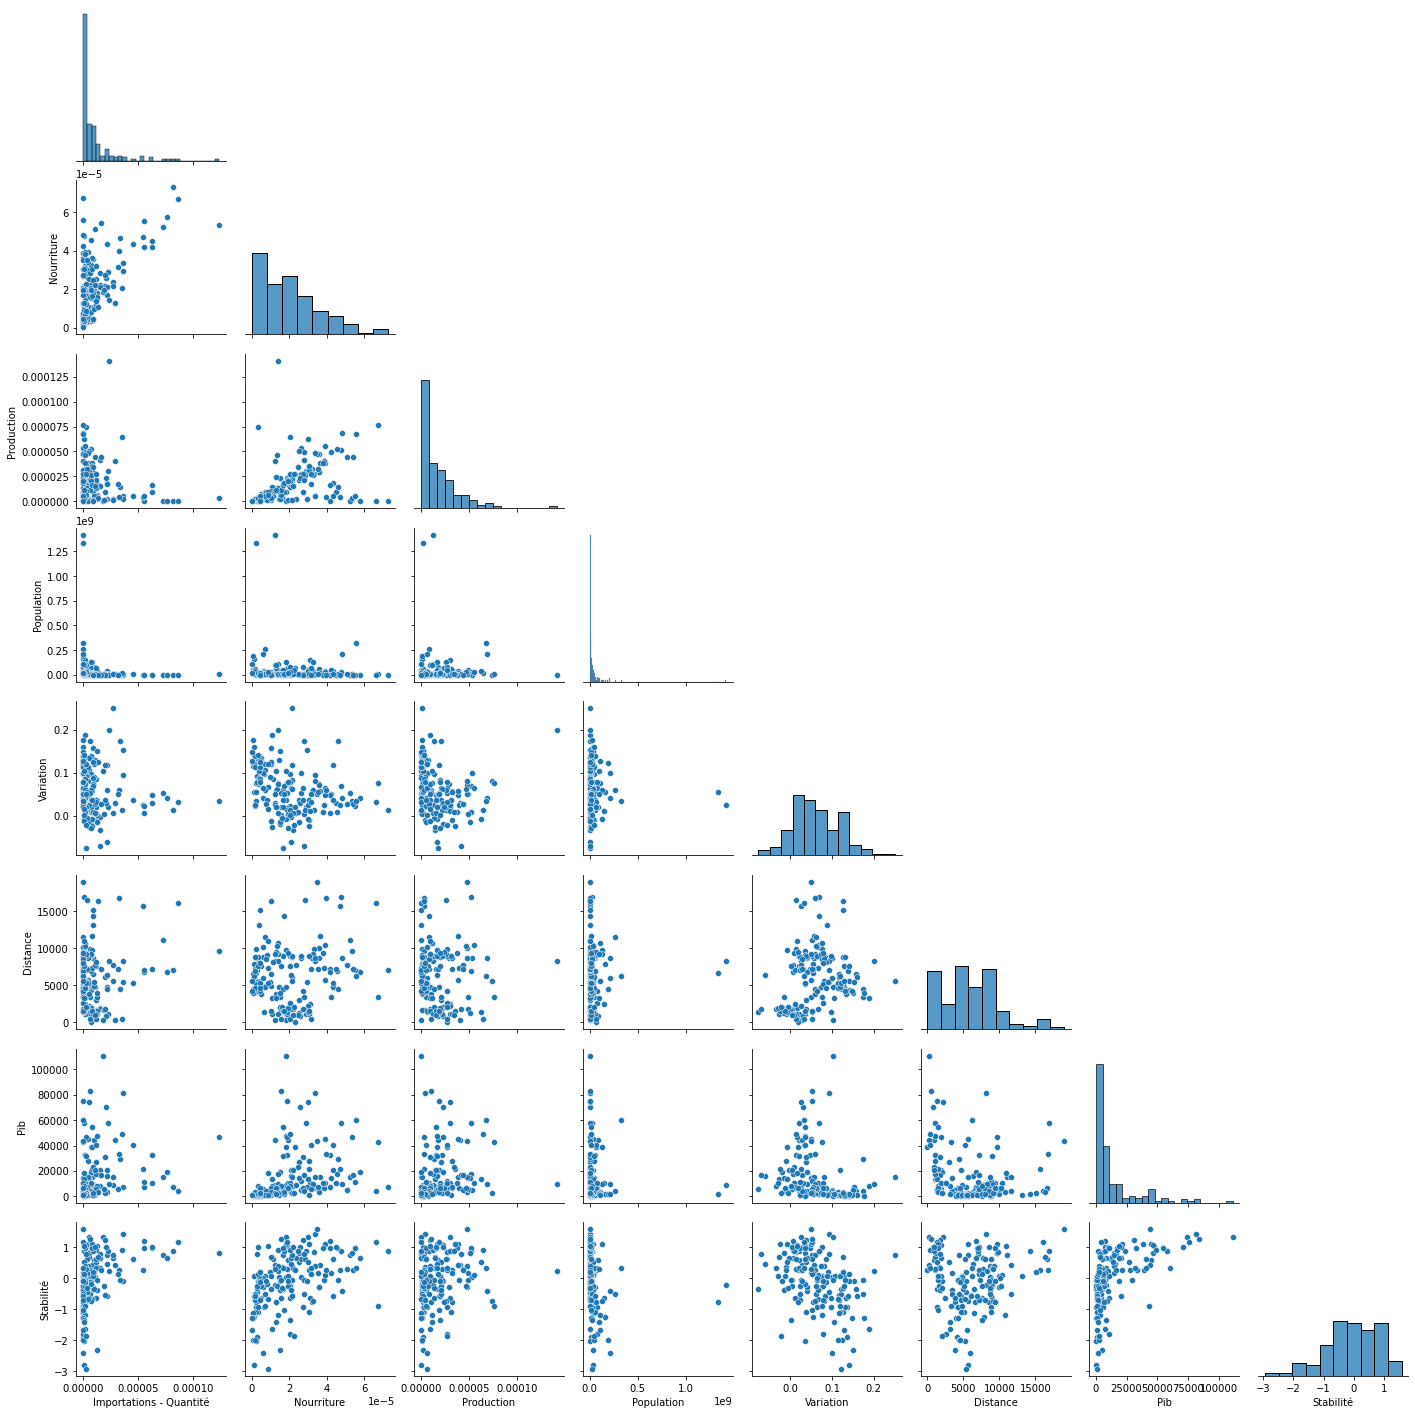

In [33]:
sns.pairplot(df, corner=True)

In [34]:
print('Importations : ', skew(df['Importations - Quantité']))
print('Nourriture : ', skew(df['Nourriture']))
print('Production : ', skew(df['Production']))
print('Population : ', skew(df['Population']))
print('Variation : ', skew(df['Variation']))
print('Distance : ', skew(df['Distance']))
print('Pib : ', skew(df['Pib']))
print('Stabilité : ', skew(df['Stabilité']))

Importations :  3.086431476681634
Nourriture :  0.8917641755614658
Production :  2.1811138124312848
Population :  7.912535952157568
Variation :  0.3306287771166258
Distance :  0.740447218999209
Pib :  2.2243147243753505
Stabilité :  -0.6731090912020634


Grâce aux graphiques et au coefficient d'asymétrie (skewness) on voit que la colonne population est loin de suivre une loi normale. Les autres valeurs semblent moins éloignées.

In [35]:
df_log = df.copy()

In [36]:
df_log['Population'] = np.log(df_log['Population'])

On applique donc la fonction logarithme pour rendre la colonne population plus "normale".

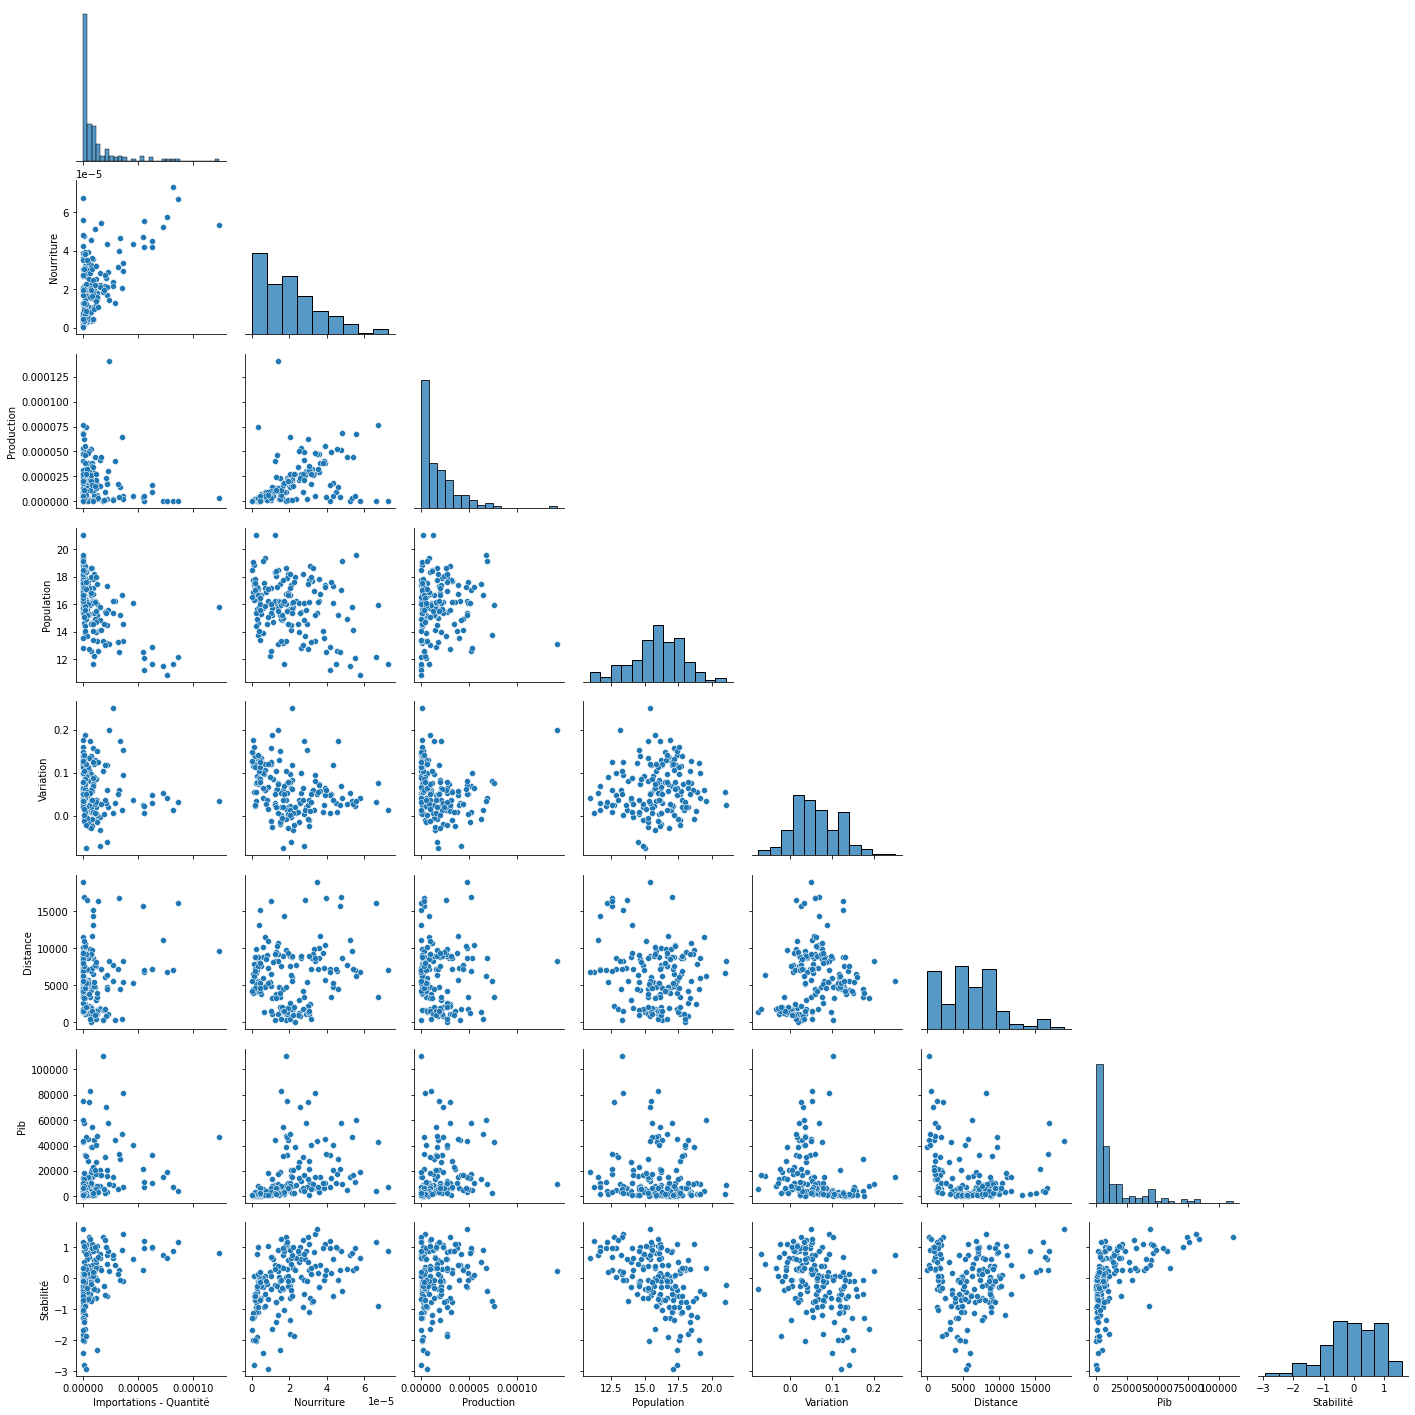

In [37]:
sns.pairplot(df_log, corner=True)

On vérifie le résultat. On voit que la colonne population suit beaucoup plus une loi normale.

In [42]:
df_log

,Importations - Quantité,Nourriture,Production,Population,Variation,Distance,Pib,Stabilité
Zone,,,,,,,,
Afghanistan,7.989836e-07,1.515314e-06,7.714325e-07,17.407221,0.141468,5572.0,520.616409,-2.80
Afrique du Sud,9.016001e-06,3.569564e-05,2.924061e-05,17.858733,0.073270,8665.0,6121.876572,-0.28
Albanie,1.317537e-05,1.629586e-05,4.507364e-06,14.874747,-0.010376,1599.0,4514.204908,0.38
Algérie,4.832180e-08,6.378477e-06,6.644247e-06,17.538530,0.096772,1336.0,4109.696001,-0.92
Allemagne,1.018650e-05,1.946565e-05,1.831635e-05,18.230227,0.020395,877.0,44651.829102,0.59
...,...,...,...,...,...,...,...,...
Émirats arabes unis,4.564043e-05,4.342692e-05,5.059447e-06,16.065454,0.036429,5229.0,40644.804043,0.62
Équateur,0.000000e+00,1.930253e-05,2.025575e-05,16.636018,0.078119,9337.0,6213.501276,-0.07
États-Unis d'Amérique,3.783629e-07,5.567779e-05,6.741011e-05,19.599596,0.033963,6151.0,59921.674703,0.34


In [41]:
df_log.to_csv('./data/analyse/data_analyse.csv', index = True)